# Knowledge extraction from the OpenReview dataset throught text clustering and embedding

The analysis work was done on the OpenReview dataset available at "https://github.com/Seafoodair/Openreview/tree/master/data", in the form of a collection of .xlsx files, where each file relates to a specific year of paper submission. The dataset, called "CLR data," is a collection of scientific peer reviews made available to support research on this important aspect of the scientific process. It includes information on more than 10,000 papers and their acceptance or rejection decisions at high-level conferences such as ICLR, as well as more than 40,000 reviews written by reviewers. To reduce the computational cost and promote experimentation, only the 2020 ICLR conference file was considered, which contains 7,766 reviews associated with 2,558 different papers. <br> <br>
After that, in a pre-processing step the columns were filtered and cleaned of any "noise" that was not useful for analysis, creating a consistent basis for further analysis. <br>
The 'analysis on the data was first conducted at a global level, highlighting trends and general characteristics, analyzing both papers and reviews, extracting both qualitative and quantitative aspects, such as the distribution of scores given, the average length of texts, highlighting more frequent keywords in titles, to identify recurring topics and thematic correlations. <br>
Then a more local analysis was conducted, attempting to vectorize by embedding methods the papers, and then trying to divide them into coherent and homogeneous groups by clustering algorithms, thus being able to then analyze each group so found to see if there are deeper patterns or biases, such as whether the reviewers' expertise is directed toward a specific application area, and whether there are factors that influence acceptance or rejection <br> <br>

First, we import all the libraries subsequently needed into the notebook:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import re

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics import normalized_mutual_info_score

from sentence_transformers import SentenceTransformer
import umap
import hdbscan

We upload data related to the ICLR 2020 conference. The file is in Excel format and contains, for each paper, one or more rows corresponding to the reviews received. Each row includes several pieces of information: the text of the review, the score assigned by the reviewer, the stated level of experience, the abstract of the paper, and some other columns related to publication and timing, some examples are shown below.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

file_path = "/content/drive/MyDrive/tp_2020conference.xlsx"

df =  pd.read_excel(file_path)

print(df.columns)
# return first 5 rows
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['title', 'publish_time', 'abstract', 'keyword', 'tL_DL', 'titlelength',
       'paper_decision_time', 'paper_decision', 'paper_decision_comment',
       'paper_decision_commentlength', 'review_publish_time', 'reviewer_level',
       'paper_score', 'rate', 'review_score_one', 'review_score_two',
       'review_score_three', 'review', 'review_contentlength'],
      dtype='object')


,title,publish_time,abstract,keyword,tL_DL,titlelength,paper_decision_time,paper_decision,paper_decision_comment,paper_decision_commentlength,review_publish_time,reviewer_level,paper_score,rate,review_score_one,review_score_two,review_score_three,review,review_contentlength
0,"Carpe Diem, Seize the Samples Uncertain *at th...",26 Sep 2019 (modified: 20 Dec 2019),Abstract:###The performance of deep neural net...,"Keywords:###batch selection, uncertain sample,...",TL;DR:###We explore the issue of truly uncerta...,97,20 Dec 2019 (modified: 20 Dec 2019),Decision:###Reject,Comment:###The authors propose a new mini-batc...,847,26 Oct 2019 (modified: 23 Nov 2019) 15 Nov 2019,Experience Assessment:###I have published in t...,Rating:###3: Weak Reject,3.0,Review Assessment: Thoroughness In Paper Readi...,Review Assessment: Checking Correctness Of Exp...,Review Assessment: Checking Correctness Of Der...,"This paper proposes Recency Bias, an adaptive...",5156
1,"Carpe Diem, Seize the Samples Uncertain *at th...",26 Sep 2019 (modified: 20 Dec 2019),Abstract:###The performance of deep neural net...,"Keywords:###batch selection, uncertain sample,...",TL;DR:###We explore the issue of truly uncerta...,97,20 Dec 2019 (modified: 20 Dec 2019),Decision:###Reject,Comment:###The authors propose a new mini-batc...,847,23 Oct 2019 (modified: 06 Nov 2019) 15 Nov 2019,Experience Assessment:###I have read many pape...,Rating:###3: Weak Reject,3.0,Review Assessment: Thoroughness In Paper Readi...,Review Assessment: Checking Correctness Of Exp...,Review Assessment: Checking Correctness Of Der...,Review:###This paper proposes an interesting h...,1877
2,"Carpe Diem, Seize the Samples Uncertain *at th...",26 Sep 2019 (modified: 20 Dec 2019),Abstract:###The performance of deep neural net...,"Keywords:###batch selection, uncertain sample,...",TL;DR:###We explore the issue of truly uncerta...,97,20 Dec 2019 (modified: 20 Dec 2019),Decision:###Reject,Comment:###The authors propose a new mini-batc...,847,17 Oct 2019 (modified: 06 Nov 2019) 15 Nov 2019,Experience Assessment:###I do not know much ab...,Rating:###6: Weak Accept,6.0,Review Assessment: Thoroughness In Paper Readi...,Review Assessment: Checking Correctness Of Exp...,Review Assessment: Checking Correctness Of Der...,Review:###This paper explores a well motivated...,2026
3,Prestopping: How Does Early Stopping Help Gene...,26 Sep 2019 (modified: 20 Dec 2019),Abstract:###Noisy labels are very common in re...,"Keywords:###noisy label, label noise, robustne...",TL;DR:###We propose a novel two-phase training...,90,20 Dec 2019 (modified: 20 Dec 2019),Decision:###Reject,Comment:###This paper focuses on avoiding over...,940,30 Oct 2019 (modified: 06 Nov 2019) 14 Nov 201...,Experience Assessment:###I have read many pape...,Rating:###3: Weak Reject,3.0,Review Assessment: Thoroughness In Paper Readi...,Review Assessment: Checking Correctness Of Exp...,Review Assessment: Checking Correctness Of Der...,Review:###This paper proposes a training strat...,2640
4,Prestopping: How Does Early Stopping Help Gene...,26 Sep 2019 (modified: 20 Dec 2019),Abstract:###Noisy labels are very common in re...,"Keywords:###noisy label, label noise, robustne...",TL;DR:###We propose a novel two-phase training...,90,20 Dec 2019 (modified: 20 Dec 2019),Decision:###Reject,Comment:###This paper focuses on avoiding over...,940,30 Oct 2019 (modified: 06 Nov 2019) 14 Nov 201...,Experience Assessment:###I have read many pape...,Rating:###6: Weak Accept,6.0,Review Assessment: Thoroughness In Paper Readi...,Review Assessment: Checking Correctness Of Exp...,Review Assessment: Checking Correctness Of Der...,Review:###This paper presents a training appro...,1418


Taking a first look at the table, we can notice the presence of many columns related to temporal metadata (such as publication and decision dates) or noisy informations as 'Keywords###' that precedes the text in the keyword column. Some of these will not be useful for analysis, so they will be removed.
<br> <br>
Before the preprocessing, we visualize the composition of the dataset in terms of data types and number of non-null values. This allows us to identify fields with missing or inconsistent data.

In [ ]:
# visualize non-null count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7766 entries, 0 to 7765
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         7766 non-null   object 
 1   publish_time                  7766 non-null   object 
 2   abstract                      7766 non-null   object 
 3   keyword                       6899 non-null   object 
 4   tL_DL                         5789 non-null   object 
 5   titlelength                   7766 non-null   int64  
 6   paper_decision_time           7760 non-null   object 
 7   paper_decision                6691 non-null   object 
 8   paper_decision_comment        6733 non-null   object 
 9   paper_decision_commentlength  7766 non-null   int64  
 10  review_publish_time           7766 non-null   object 
 11  reviewer_level                7766 non-null   object 
 12  paper_score                   7766 non-null   object 
 13  rat

Rate and Paper Score represent the same value, which is the score associated with the paper by a reviewer. <br> In the Paper Score column the content is in text format (e.g., "6: Strong accept"), where each rating is reported as to whether it results in acceptance or rejection. In the rate column, only the numeric value is reported, but as can be seen from the non-null count, it is often missing, so only the paper_score column with only the assigned value will be maintained, with the understanding that above the threshoold = 5, the paper is accepted and below rejected. <br> <br> Below we check which types of reviewer_level there are, to convert it to a numerical representation. <br> Reviewer_level represents the expertice level of the reviewer with reference to the paper's area of interest.






In [ ]:
df['reviewer_level'].value_counts(dropna=False)

,count
reviewer_level,
Experience Assessment:###I have published one or two papers in this area.,2659
Experience Assessment:###I have read many papers in this area.,2554
Experience Assessment:###I have published in this field for several years.,1449
Experience Assessment:###I do not know much about this area.,1104


# Preprocessing & Cleaning

In [ ]:
#Filters out unwanted columns
cols_to_drop = [
    'publish_time', 'titlelength', 'paper_decision_time', 'rate',
     'review_publish_time'
]
# Remove only the columns actually present in the DataFrame to avoid errors
df_filtered = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# Removes prefixes of type '###' from all string cells and apply it to the columns of the DataFrame
def clean_prefix(text):
    if isinstance(text, str):
        return text.split("###")[-1].strip()
    return text

for col in df_filtered.columns:
    df_filtered[col] = df_filtered[col].apply(clean_prefix)

# Converts 'paper_score' to number, extracting the numeric part
if 'paper_score' in df_filtered.columns and df_filtered['paper_score'].dtype == 'object':
    df_filtered['paper_score'] = df_filtered['paper_score'].str.extract(r'(\d+)').astype(float)

# Map the reviewer's experience levels on a numerical scale and replace the column with the numerical representation
reviewer_level_map = {
    "I do not know much about this area.": 0.0,
    "I have read many papers in this area.": 1.0,
    "I have published one or two papers in this area.": 2.0,
    "I have published in this field for several years.": 3.0
}
if 'reviewer_level' in df_filtered.columns:
    df_filtered['reviewer_level'] = df_filtered['reviewer_level'].map(reviewer_level_map)

# Count how many reviews for each item
if 'title' in df_filtered.columns:
    review_counts = df_filtered['title'].value_counts().reset_index()
    review_counts.columns = ['title', 'num_reviews']
    df_filtered = df_filtered.merge(review_counts, on='title', how='left')

# We want to convert the keywords for each article from a single string to a list containing the single keywords, To simplify the processing and extraction of information
def split_keywords(kw_string):
    if pd.isnull(kw_string):
        return []
    if isinstance(kw_string, str):
        keywords = [kw.strip().lower() for kw in kw_string.split(',') if kw.strip()]
        return keywords
    return []

if 'keyword' in df_filtered.columns:
    df_filtered['keyword'] = df_filtered['keyword'].apply(split_keywords)

# Compute abstract length (number of words)
if 'abstract' in df_filtered.columns:
    df_filtered['abstract_length'] = df_filtered['abstract'].apply(lambda x: len(str(x).split()))

# show filtered and cleaned table

df_filtered.head()



,title,abstract,keyword,tL_DL,paper_decision,paper_decision_comment,paper_decision_commentlength,reviewer_level,paper_score,review_score_one,review_score_two,review_score_three,review,review_contentlength,num_reviews,abstract_length
0,"Carpe Diem, Seize the Samples Uncertain *at th...",The performance of deep neural networks is sig...,"[batch selection, uncertain sample, accelerati...",We explore the issue of truly uncertain sample...,Reject,The authors propose a new mini-batch selection...,847,3.0,3.0,I read the paper at least twice and used my be...,I carefully checked the experiments.,I assessed the sensibility of the derivations ...,"This paper proposes Recency Bias, an adaptive ...",5156,3,137
1,"Carpe Diem, Seize the Samples Uncertain *at th...",The performance of deep neural networks is sig...,"[batch selection, uncertain sample, accelerati...",We explore the issue of truly uncertain sample...,Reject,The authors propose a new mini-batch selection...,847,1.0,3.0,I read the paper at least twice and used my be...,I assessed the sensibility of the experiments.,I assessed the sensibility of the derivations ...,This paper proposes an interesting heuristic o...,1877,3,137
2,"Carpe Diem, Seize the Samples Uncertain *at th...",The performance of deep neural networks is sig...,"[batch selection, uncertain sample, accelerati...",We explore the issue of truly uncertain sample...,Reject,The authors propose a new mini-batch selection...,847,0.0,6.0,I read the paper thoroughly.,I carefully checked the experiments.,I assessed the sensibility of the derivations ...,This paper explores a well motivated but very ...,2026,3,137
3,Prestopping: How Does Early Stopping Help Gene...,Noisy labels are very common in real-world tra...,"[noisy label, label noise, robustness, deep le...",We propose a novel two-phase training approach...,Reject,This paper focuses on avoiding overfitting in ...,940,1.0,3.0,I read the paper at least twice and used my be...,I assessed the sensibility of the experiments.,I assessed the sensibility of the derivations ...,This paper proposes a training strategy for ro...,2640,4,132
4,Prestopping: How Does Early Stopping Help Gene...,Noisy labels are very common in real-world tra...,"[noisy label, label noise, robustness, deep le...",We propose a novel two-phase training approach...,Reject,This paper focuses on avoiding overfitting in ...,940,1.0,6.0,I read the paper thoroughly.,I carefully checked the experiments.,I carefully checked the derivations and theory.,This paper presents a training approach on lab...,1418,4,132


# Plotting & Visualizing global statistics

Before turning to embedding and clustering methods, it is essential to understand the distribution and overall characteristics of the available data to:

- identify any anomalies or imbalances in the data

- recognize initial patterns related to review length, scores, or keywords

- check whether certain characteristics (such as reviewer experience or abstract length) correlate with paper outcome.

Because the dataset is organized at a review level, we build another DataFrame aggregating the information to a paper level. This step allows for a cooherent extraction of statistics, being that some papers have more reviews and therefore more rows :

In [ ]:
# From a "review level" table to a "paper level" dataframe

df_copy = df_filtered.copy()

# we will drop unwanted columns and non-aggregable information
cols_to_drop = ['paper_decision_commentlength',	'review_score_one', 'review_score_two', 'review_score_three', 'review', 'review_contentlength']

df_copy.drop(columns=[col for col in cols_to_drop if col in df_copy.columns], inplace=True)

# Group by 'title' and calculate average of numeric columns
df_grouped = df_copy.groupby('title', as_index=False).agg({
    'abstract': 'first',
    'keyword': 'first',
    'tL_DL': 'first',
    'paper_decision': 'first',
    'paper_decision_comment': 'first',
    'reviewer_level': 'mean',
    'paper_score': 'mean',
    'num_reviews': 'first',
    'abstract_length': 'first'
})
df_grouped.head()



,title,abstract,keyword,tL_DL,paper_decision,paper_decision_comment,reviewer_level,paper_score,num_reviews,abstract_length
0,$\textrm{D}^2$GAN: A Few-Shot Learning Approac...,The rich and accessible labeled data fuel the ...,"[few-shot learning, generative adversarial net...",A new GAN based few-shot learning algorithm by...,None,None,2.333333,3.333333,3,198
1,$ell_1$ Adversarial Robustness Certificates: a...,Robustness is an important property to guarant...,[],We derive the first tight robustness certifica...,Reject,"After reading the author*s response, all the r...",2.000000,4.000000,3,98
2,3D-SIC: 3D Semantic Instance Completion for RG...,This paper introduces the task of semantic ins...,"[3d reconstruction, rgb-d scanning, 3d learnin...","From an incomplete RGB-D scan of a scene, we a...",None,None,1.333333,4.000000,3,178
3,A Base Model Selection Methodology for Efficie...,While the accuracy of image classification ach...,"[transfer learning, fine-tuning, parameter tra...",We propose several metrics to estimate the tra...,Reject,This paper proposes to speed up finetuning of ...,2.000000,3.000000,3,208
4,A Baseline for Few-Shot Image Classification |...,Fine-tuning a deep network trained with the st...,"[few-shot learning, transductive learning, fin...",Transductive fine-tuning of a deep network is ...,Accept (Poster),This paper introduces a simple baseline for fe...,2.000000,6.000000,3,142


We now compute summary statistics on the aggregated, paper-level table using the .describe() method. This allows us to observe:

- the number of valid entries for each field

- the mean and standard deviation

- the minimum and maximum values, useful to detect potential outliers

- the median (50% percentile), to estimate of the central value of each distribution

From the output, we can also see the total number of papers in the dataset (2558).



In [ ]:
df_grouped.describe(percentiles=[])

,reviewer_level,paper_score,num_reviews,abstract_length
count,2558.000000,2558.000000,2558.000000,2558.000000
mean,1.574238,4.178844,3.035966,163.253323
std,0.595032,1.708938,0.337171,44.537478
min,0.000000,1.000000,2.000000,33.000000
50%,1.666667,4.000000,3.000000,159.000000
max,3.000000,8.000000,5.000000,402.000000


--------------------------------------------------------------------

 We examine the distribution of the textual content length — specifically, the number of characters in abstracts and reviews. This gives a first indication of how detailed the evaluations tend to be, and can later be compared with variables such as reviewer experience or final paper scores.

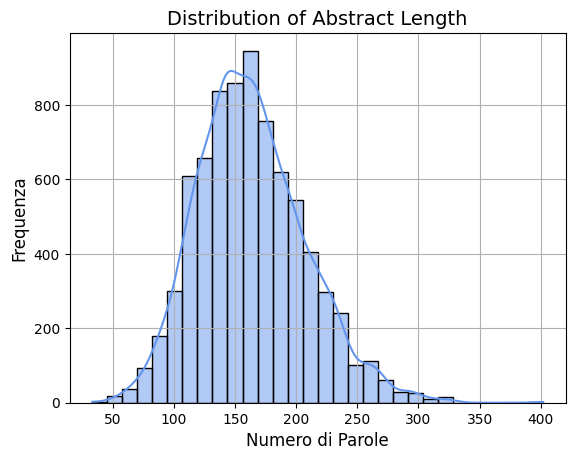

,abstract_length
count,7766.000000
mean,163.256889
std,44.441490
min,33.000000
25%,133.000000
50%,159.000000
75%,191.000000
max,402.000000


In [ ]:
sns.histplot(df_filtered['abstract_length'], bins=30, kde=True, color='cornflowerblue')
plt.title('Distribution of Abstract Length', fontsize=14)
plt.xlabel('Numero di Parole', fontsize=12)
plt.ylabel('Frequenza', fontsize=12)
plt.grid(True)
plt.show()

df_filtered['abstract_length'].describe()

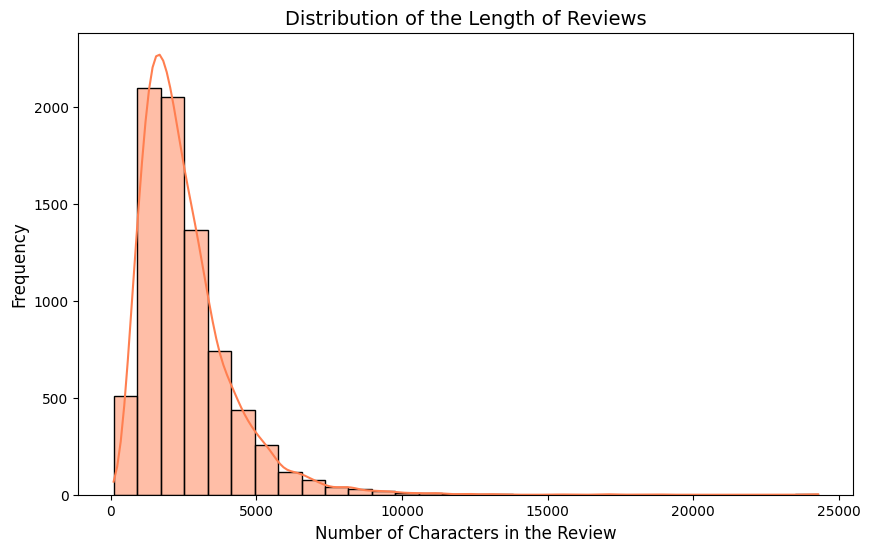

,review_contentlength
count,7766.000000
mean,2561.600180
std,1611.515221
min,107.000000
25%,1484.250000
50%,2182.000000
75%,3179.000000
max,24287.000000


In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['review_contentlength'].dropna(), bins=30, kde=True, color='coral')
plt.title('Distribution of the Length of Reviews', fontsize=14)
plt.xlabel('Number of Characters in the Review', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

df['review_contentlength'].describe()

We now look at the distribution of the self-reported reviewer experience levels to see how balanced the dataset is in terms of expertise among reviewers.

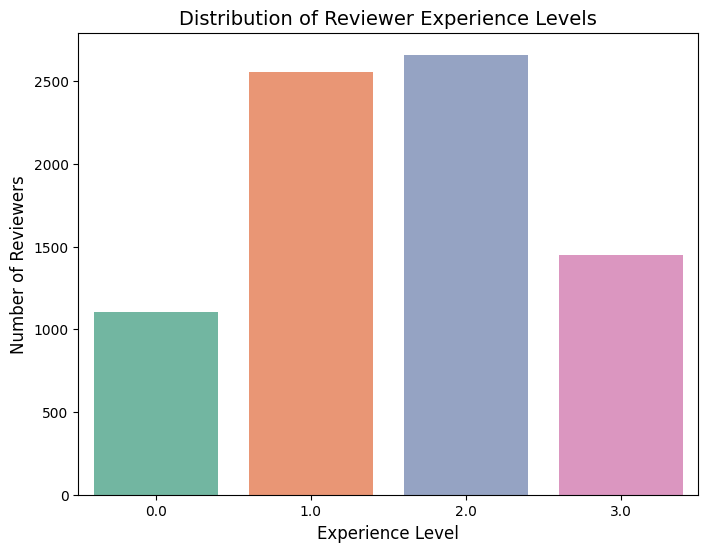

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='reviewer_level', hue='reviewer_level', data=df_filtered, palette='Set2', legend=False)
plt.title('Distribution of Reviewer Experience Levels', fontsize=14)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Number of Reviewers', fontsize=12)
plt.show()


The distribution is fairly balanced, though the majority of reviewers report moderate to high familiarity with the topics. Only a small portion declare low expertise.

We now examine the distribution of average paper scores, computed by aggregating multiple reviews per paper.<br> Although the original scores are discrete values (1, 3, 6, 8), the averaging process results in a continuous distribution of intermediate values.

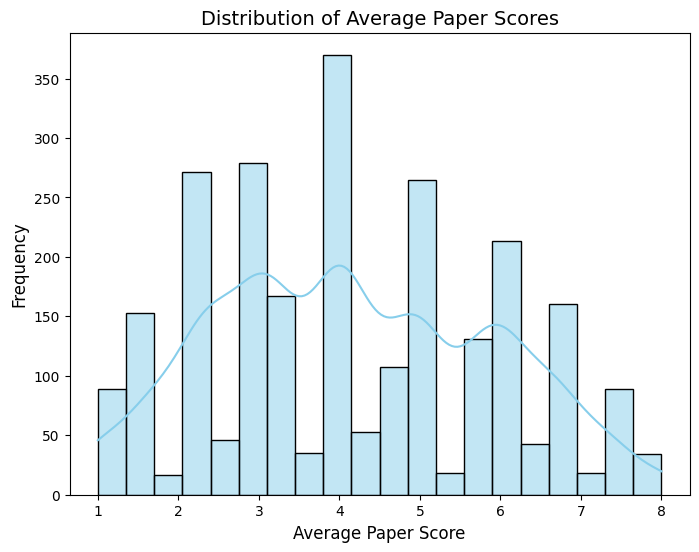

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_grouped['paper_score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Average Paper Scores', fontsize=14)
plt.xlabel('Average Paper Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


The distribution shows a peak around a score of 4, a value that cannot be assigned directly, but derives from the average of conflicting scores (e.g., one reviewer gives a 3(weak rejection) and another a 6(weak acceptance)). This suggests a high frequency of disagreement in the review process. Since the acceptance threshold is set at 5, a large number of papers fall just below the decision boundary, highlighting the challenge of reaching consensus during peer review. <br> To further explore this, we visualize the distribution of average scores separately for accepted and rejected papers, using the actual acceptance decisions from the dataset. This helps clarify how closely the average rating aligns with the final outcome.

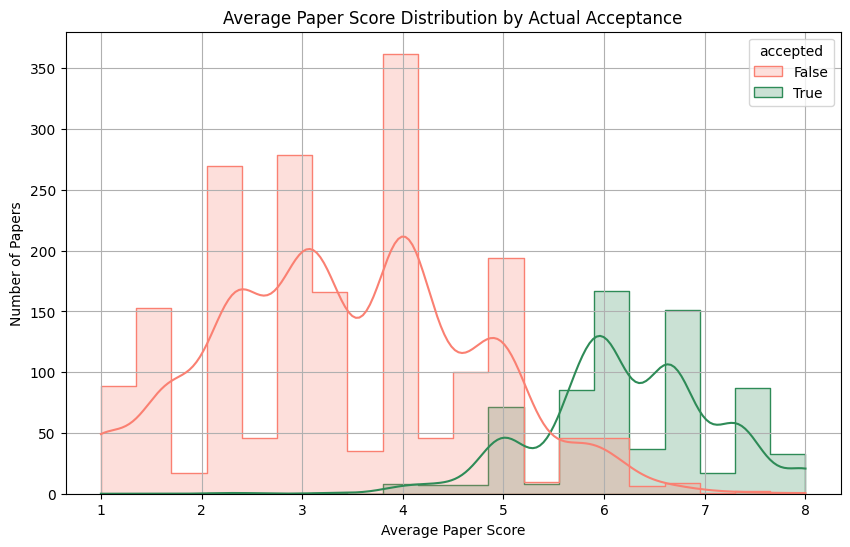

In [ ]:
# Create clean 'accepted' (boolean value)
df_grouped['accepted'] = df_grouped['paper_decision'].fillna('').str.lower().str.contains('accept')

# Drop rows with missing values
df_plot = df_grouped[['paper_score', 'accepted']].dropna()

plt.figure(figsize=(10, 6))
sns.histplot(data=df_plot, x='paper_score', hue='accepted', bins=20, kde=True,
             palette={True: 'seagreen', False: 'salmon'}, element='step')
plt.title('Average Paper Score Distribution by Actual Acceptance')
plt.xlabel('Average Paper Score')
plt.ylabel('Number of Papers')
plt.grid(True)
plt.show()


The overlap illustrates the ambiguity in borderline cases, where similar average scores can lead to different outcomes, likely depending on qualitative factors in the reviews or reiviews with a different weight given from the reviewers experience.



We analyze the distribution of review lengths in relation to two variables: the paper score and the reviewer’s self-declared level of expertise. The idea is to explore whether more detailed reviews (in terms of word count) correlate with stronger or weaker evaluations, and whether reviewer experience influences the level of detail provided.

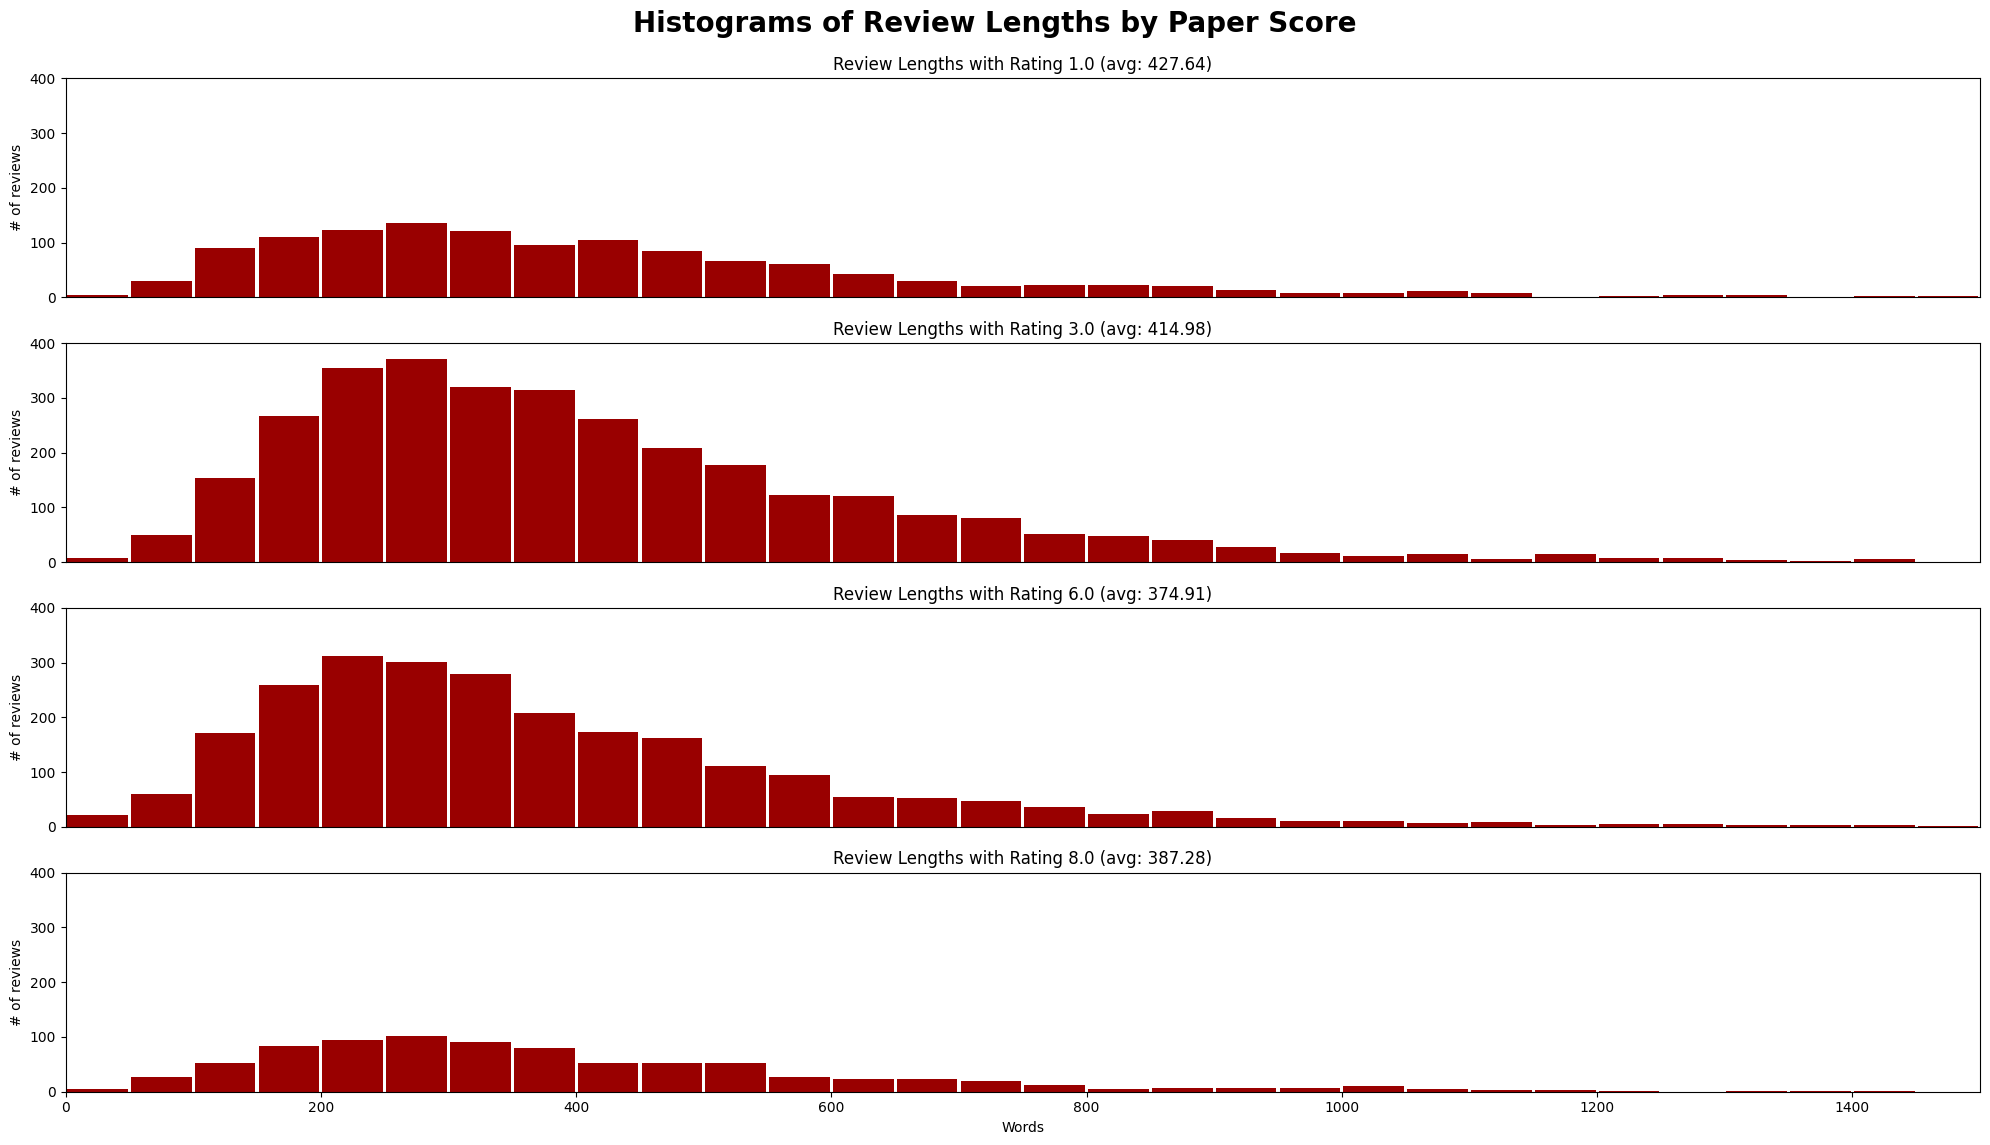

In [ ]:
review_texts = df_filtered['review'].fillna('')
ratings = df_filtered['paper_score'].values
review_lengths = review_texts.apply(lambda x: len(str(x).split())).values

interval = 50
bins = [v * interval for v in range((np.max(review_lengths) // interval) + 1)]
unique_ratings = np.sort(df_filtered['paper_score'].dropna().unique())

gs = gridspec.GridSpec(len(unique_ratings), 1)
fig = plt.figure(figsize=(20, 12))

for i, unique_rating in enumerate(unique_ratings):
    plt.subplot(gs[i])

    # Filter reviews with that rating
    all_review_len_rating = review_lengths[ratings == unique_rating]

    plt.title(f'Review Lengths with Rating {unique_rating} (avg: {np.mean(all_review_len_rating):.2f})')
    plt.hist(all_review_len_rating, bins=bins, color='#990000', rwidth=0.95)

    if i == len(unique_ratings) - 1:
        plt.xlabel('Words')
    else:
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    plt.ylim(0, 400)
    plt.xlim(0, 1500)
    plt.ylabel('# of reviews')

fig.suptitle('Histograms of Review Lengths by Paper Score', fontsize=20, fontweight='bold', y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


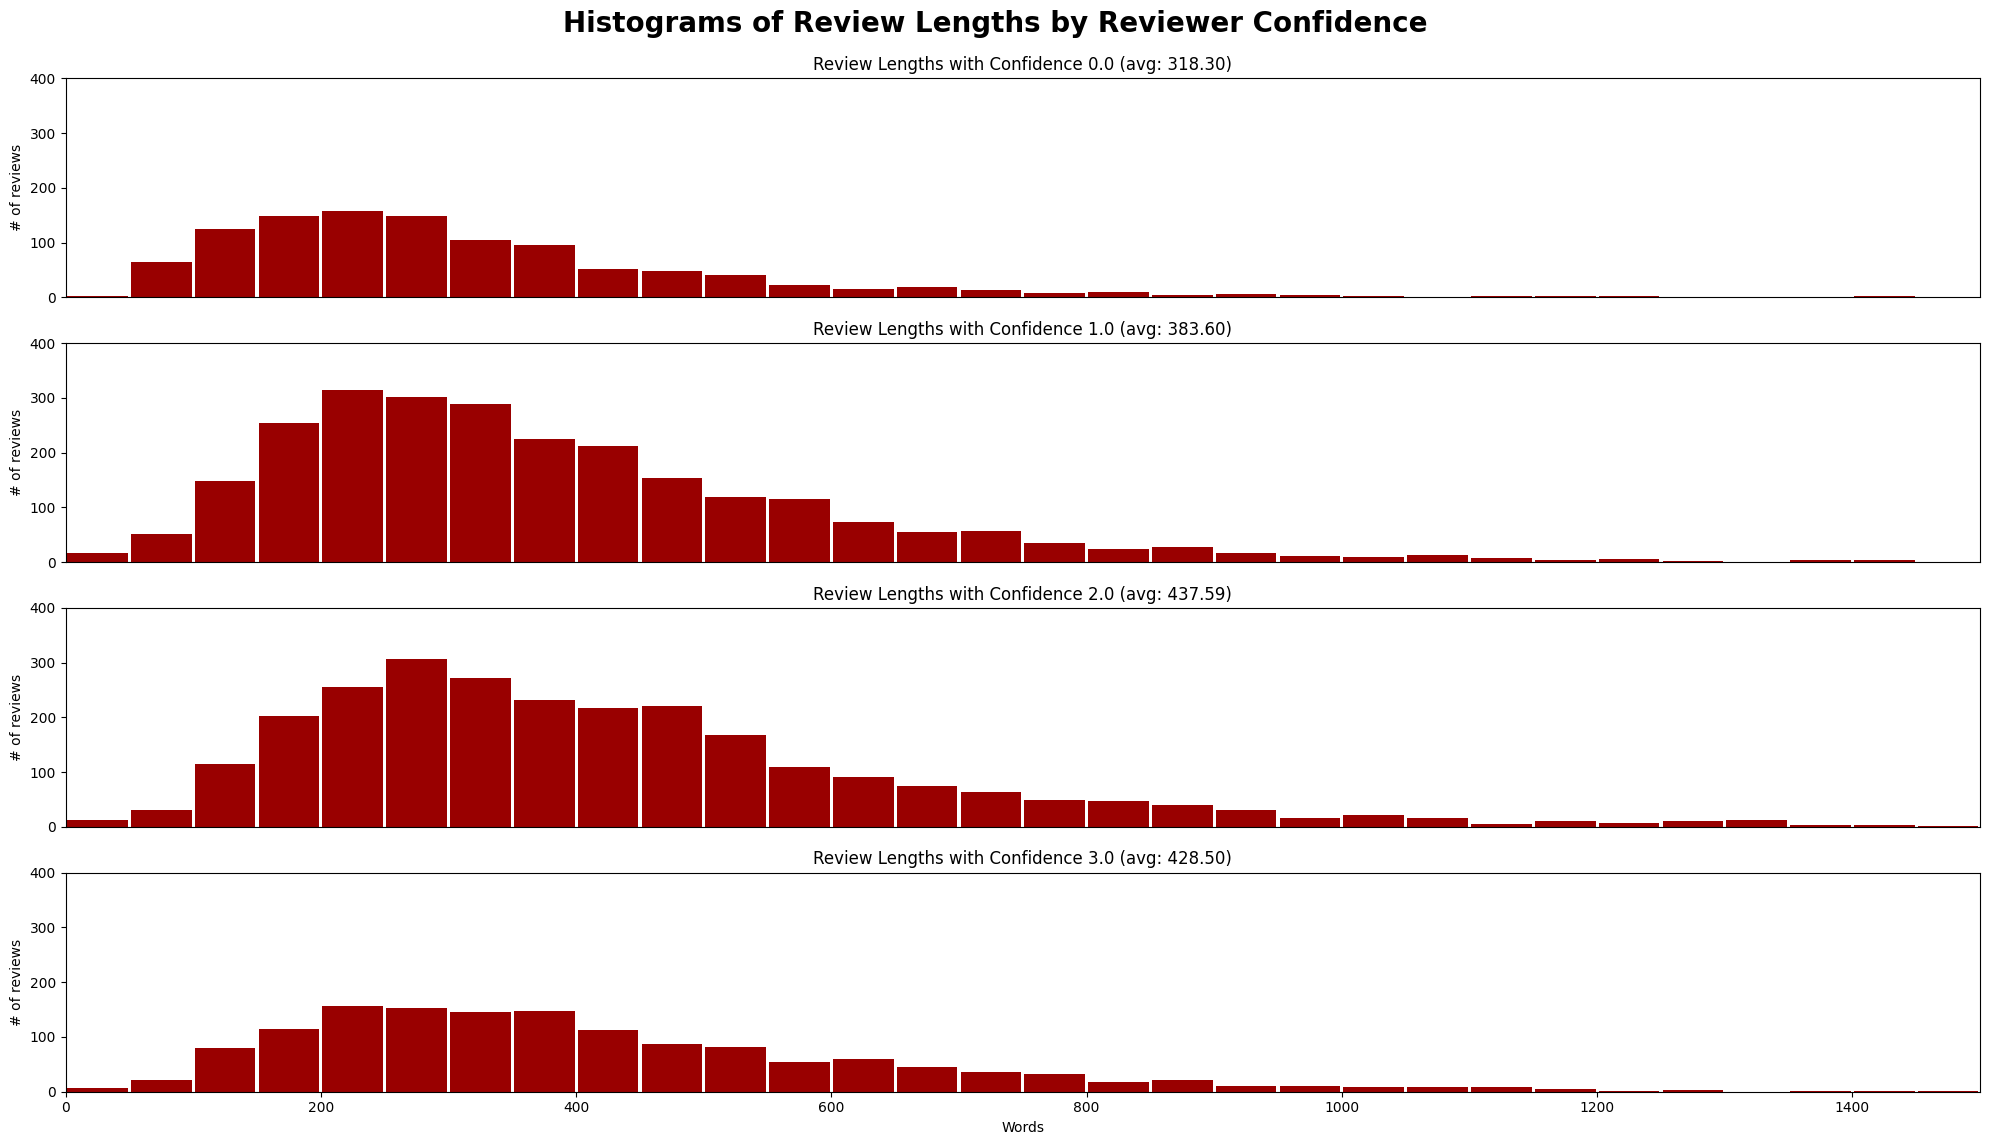

In [ ]:
review_texts = df_filtered['review'].fillna('')
confidences = df_filtered['reviewer_level'].dropna().values
review_lengths = review_texts.apply(lambda x: len(str(x).split())).values

interval = 50
bins = [v * interval for v in range((np.max(review_lengths) // interval) + 1)]
unique_confidences = np.sort(np.unique(confidences))

gs = gridspec.GridSpec(len(unique_confidences), 1)
fig = plt.figure(figsize=(20, 12))

for i, unique_confidence in enumerate(unique_confidences):
    plt.subplot(gs[i])

    # Filter reviews with that confidence level
    all_review_len_conf = review_lengths[df_filtered['reviewer_level'] == unique_confidence]

    plt.title(f'Review Lengths with Confidence {unique_confidence} (avg: {np.mean(all_review_len_conf):.2f})')
    plt.hist(all_review_len_conf, bins=bins, color='#990000', rwidth=0.95)

    if i == len(unique_confidences) - 1:
        plt.xlabel('Words')
    else:
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    plt.ylim(0, 400)
    plt.xlim(0, 1500)
    plt.ylabel('# of reviews')

fig.suptitle('Histograms of Review Lengths by Reviewer Confidence', fontsize=20, fontweight='bold', y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


-----------------------------------------------------------------------------------------------------

<br>The following analyses explore how keyword usage relates to paper evaluation. We first identify the most frequent keywords across all submissions, then examine how each keyword correlates with average review scores. Finally, we compare keyword frequencies between accepted and rejected papers to highlight potential topical differences. <br> <br>
It is important to note that all observations are based on a single edition of the ICLR conference (2020), and the results are tied to that year's specific trends and submission pool. <br> Possible future extensions of this analysis across multiple years and conferences could reveal whether such patterns are consistent or domain-specific

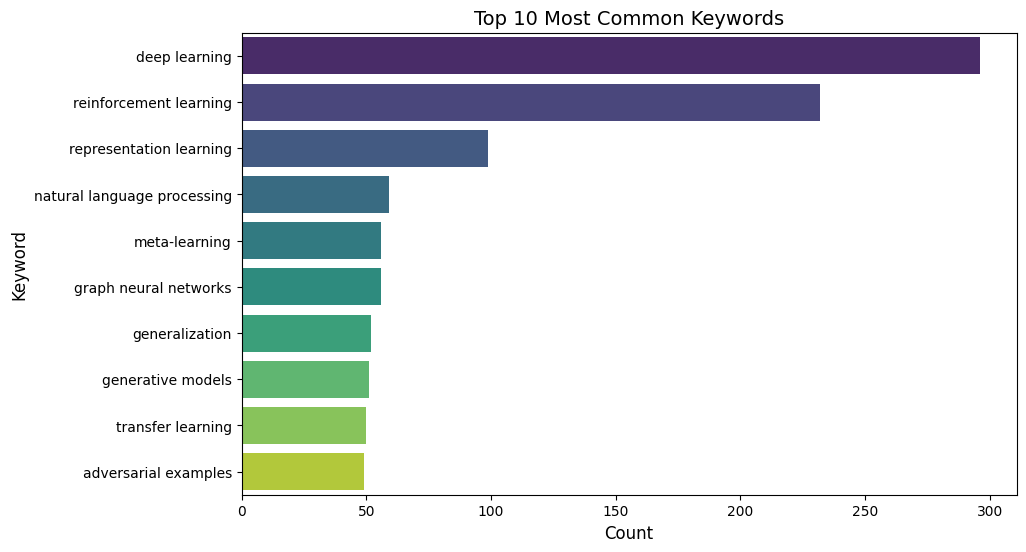

In [ ]:
# Flatten all keywords into one list
all_keywords = [kw for sublist in df_grouped['keyword'] for kw in sublist]

# Keyword frequency counts
keyword_counts = Counter(all_keywords)

top_keywords = keyword_counts.most_common(10)

# Visualizing
top_keywords_df = pd.DataFrame(top_keywords, columns=['Keyword', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Keyword', data=top_keywords_df, hue='Keyword', palette='viridis', legend=False)
plt.title('Top 10 Most Common Keywords', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Keyword', fontsize=12)
plt.show()

<ipython-input-45-9523a1302d57>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (fbin, sbin), group in t.groupby(['freq_bin', 'score_bin']):


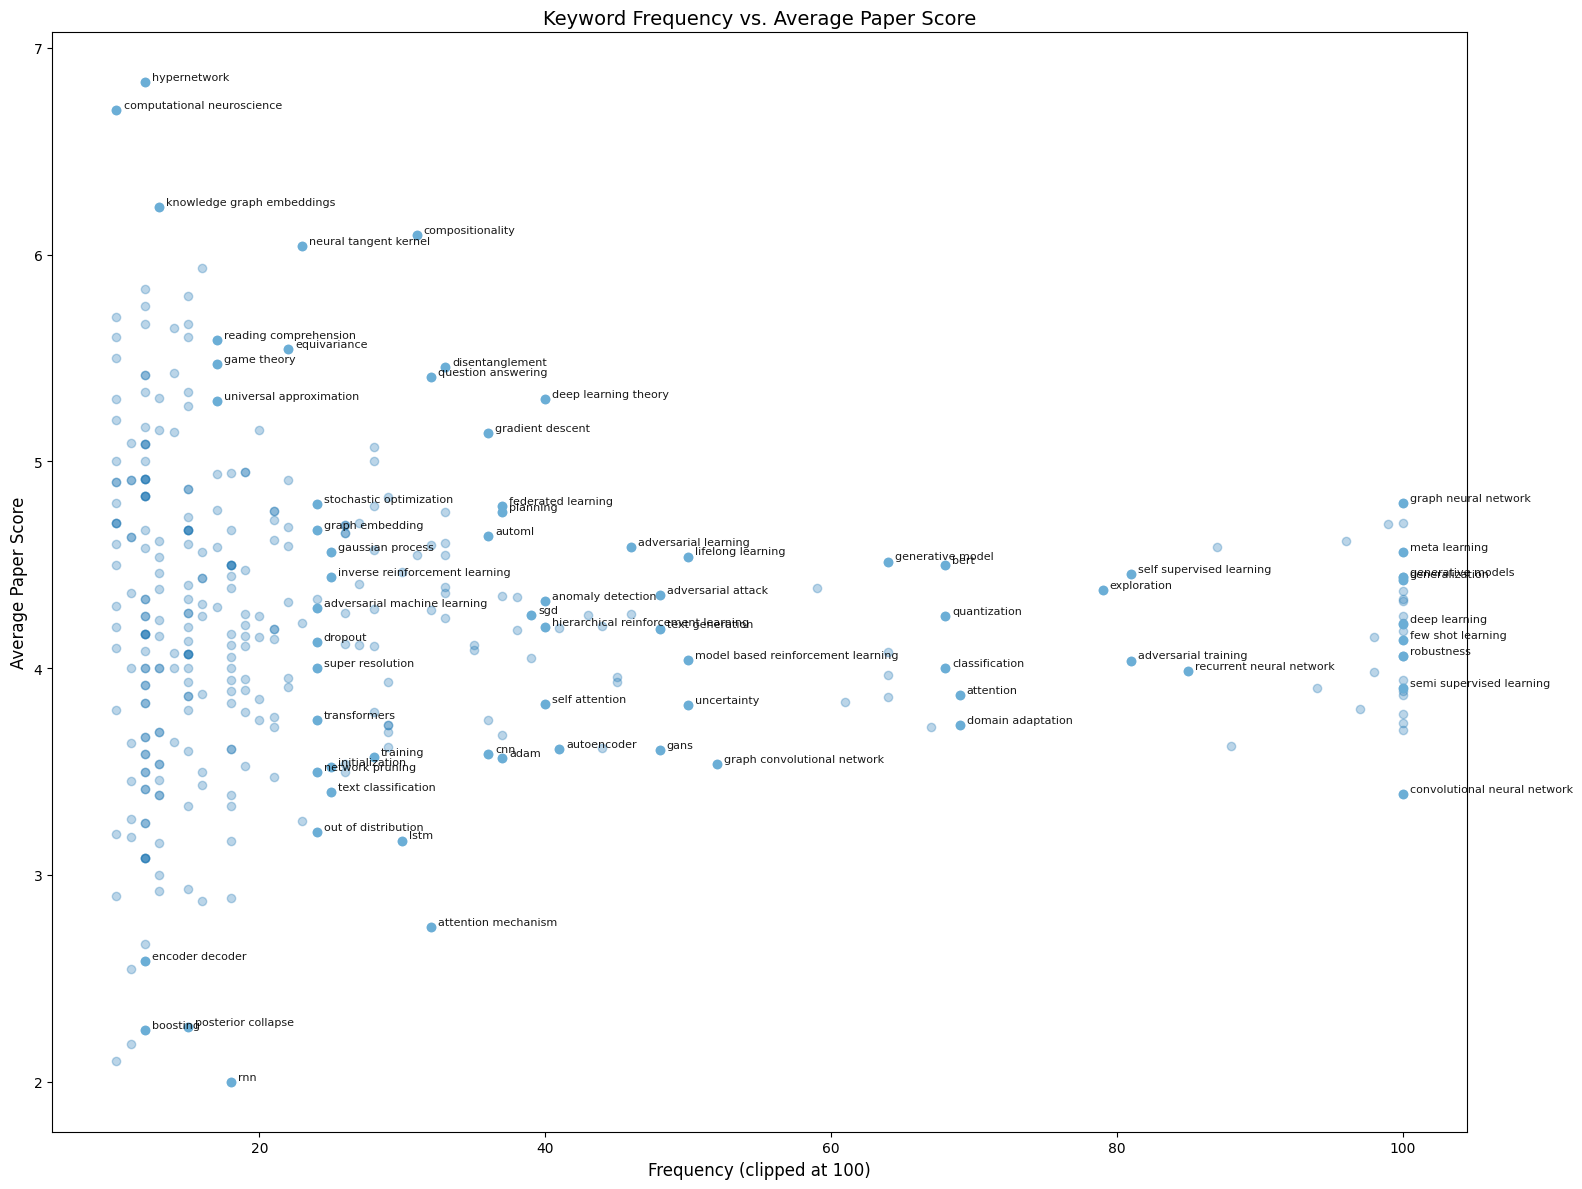

In [ ]:
# construction of keyword dictionary → score list
data = {}
for keywords, score in zip(df_filtered['keyword'], df_filtered['paper_score']):
    if not isinstance(keywords, list) or pd.isna(score):
        continue
    for keyword in keywords:
        cleaned = keyword.lower().replace('-', ' ').replace('networks', 'network').strip()
        data.setdefault(cleaned, []).append(score)

t = pd.DataFrame({
    'Frequency': [min(len(v), 100) for v in data.values()],
    'AverageScore': [np.mean(v) for v in data.values()],
    'Keyword': list(data.keys())
}).query('Frequency > 9')

# bin (avg score x frequency)
n_bins = 6
freq_bins = pd.cut(t['Frequency'], bins=n_bins)
score_bins = pd.cut(t['AverageScore'], bins=n_bins)

t['freq_bin'] = freq_bins
t['score_bin'] = score_bins

# selecting only 4 kw for evey bin (to help visualization)
selected_rows = []
for (fbin, sbin), group in t.groupby(['freq_bin', 'score_bin']):
    selected_rows.extend(group.sort_values('Frequency', ascending=False).head(4).to_dict('records'))

plt.figure(figsize=(16, 12))
plt.scatter(t['Frequency'], t['AverageScore'], alpha=0.3, label='Tutti i punti')
plt.xlabel('Frequency (clipped at 100)', fontsize=12)
plt.ylabel('Average Paper Score', fontsize=12)
plt.title('Keyword Frequency vs. Average Paper Score', fontsize=14)

for row in selected_rows:
    plt.scatter(row['Frequency'], row['AverageScore'], color='#6baed6')
    plt.text(row['Frequency'] + 0.5, row['AverageScore'] + 0.01, row['Keyword'],
             fontsize=8, color='black', alpha=0.9)

plt.tight_layout()
plt.show()

In [ ]:
# Divide accepted/rejected
accepted_keywords = df_grouped[df_grouped['accepted']]['keyword'].dropna().sum()
rejected_keywords = df_grouped[~df_grouped['accepted']]['keyword'].dropna().sum()

accepted_counts = Counter([kw.lower() for kw in accepted_keywords])
rejected_counts = Counter([kw.lower() for kw in rejected_keywords])

keywords_df = pd.DataFrame.from_dict({
    'Accepted': accepted_counts,
    'Rejected': rejected_counts
}).fillna(0)

keywords_df['Relative Difference'] = keywords_df['Accepted'] - keywords_df['Rejected']
keywords_df = keywords_df.sort_values(by='Relative Difference', ascending=False)

keywords_df.head(10)

,Accepted,Rejected,Relative Difference
compositionality,8.0,2.0,6.0
knowledge graph embeddings,4.0,0.0,4.0
disentanglement,7.0,4.0,3.0
reinforce,3.0,0.0,3.0
computational neuroscience,3.0,0.0,3.0
relu networks,3.0,0.0,3.0
reasoning,4.0,1.0,3.0
outlier detection,4.0,1.0,3.0
implicit bias,3.0,0.0,3.0
relational learning,3.0,0.0,3.0


Some keywords appear more frequently in accepted papers than in rejected ones. The numbers in the table represent the total number of times each keyword occurs within the respective groupThis might suggest topical trends or community preferences, though causality cannot be inferred.

#Clustering e local analysis

We want to cluster the papers to find groups of similar papers in terms of area of interest/research.<br>
When attempting to cluster scientific papers according to their topics or research areas, the choice of textual representation becomes foundational to the quality and interpretability of the results <br>

Let us examine the main textual candidates for this role: keywords, titles and abstracts.<br>

From an information theory perspective, each of these fields encodes different amounts of <b>entropy</b>—i.e., unpredictability, or novelty.
- Keywords are low-entropy: they are short, standardized, often selected from a constrained vocabulary.
- Titles are also relatively low in entropy. Although written in free form, they are strongly constrained by length and academic conventions.
- Abstracts, in contrast, are high-entropy: they include nuanced phrasing, full-sentence logic, and specialized terminology.

This difference in entropy has direct implications for how we represent and cluster the documents.
To explore this, we implement and compare two distinct approaches:

- <b>TF-IDF on keywords</b> <br>
Keywords are ideal for lightweight, interpretable vectorization. Using TF-IDF yields sparse, high-dimensional vectors, where each dimension corresponds to a term in the vocabulary. However, it captures only surface-level similarity — documents sharing concepts but using different terminology may be assigned to different clusters. <br>On the computational side, this approach is extremely efficient: vectorization and clustering can be performed in seconds. The downside is that topic resolution tends to be  limited to explicit term overlap. <br>We restrict the use of TF-IDF to keywords because these fields are short, well-structured, and vocabulary-constrained — ideal conditions for frequency-based vectorization.

- <b>SBERT embeddings on abstracts</b> <br>
Abstracts encode much richer information, but require more sophisticated techniques to extract meaningful structure. We use Sentence-BERT to embed each abstract into a dense vector, where semantically similar texts lie close in the rappresentation space. This enables better cluster cohesion, especially in cases where topic similarity is not captured through shared vocabulary. <br>The trade-off is computational: each abstract must pass through a transformer-based encoder, and clustering in a dense high-dimensional space is more resource-intensive.<br>We apply SBERT only to abstracts, as they contain the highest informational content and benefit most from a semantic embedding space.

<br> We begin the TF-IDF pipeline by flattening the list of keywords across all papers and tokenizing them into individual terms. This step allows us also to estimate the vocabulary size which directly determines the dimensionality of the TF-IDF vectors.



In [ ]:
# Flatten all kw
all_keywords = [kw for kws in df_grouped['keyword'].dropna() for kw in kws]
all_words = [word for kw in all_keywords for word in re.split(r'[,\s]+', kw.strip()) if word]

unique_words = set(all_words)
print(f"Number of unique keywords (tokens): {len(unique_words)}")


Number of unique keywords (tokens): 2613


We now apply K-Means clustering to the TF-IDF representations of paper keywords, with the goal of grouping papers based on topical similarity.
<br>
Each document is first converted into a TF-IDF vector. The weight of a token <i>t</i> in document <i>d</i>  is computed as:
</p>

<p>
TF-IDF(t, d) = TF(t, d) &times; log(N / DF(t))
</p>


-  <i>TF(t, d)</i>: term frequency of token <i>t</i> in document <i>d</i></li>
-  <i>DF(t)</i>: number of documents containing token <i>t</i></li>
-  <i>N</i>: total number of documents</li>


We apply <strong>K-Means</strong> to these vectors. The algorithm partitions the documents into <i>k</i> clusters by minimizing the sum of squared distances from each point to the centroid of its assigned cluster

To determine the optimal number of clusters <i>k</i>, we use the <strong>Elbow Method</strong>. We compute the inertia for several values of <i>k</i> and select the point where the decrease in inertia slows significantly, the "elbow point".


After clustering, we examine each cluster by listing the most frequent keywords associated with its documents.


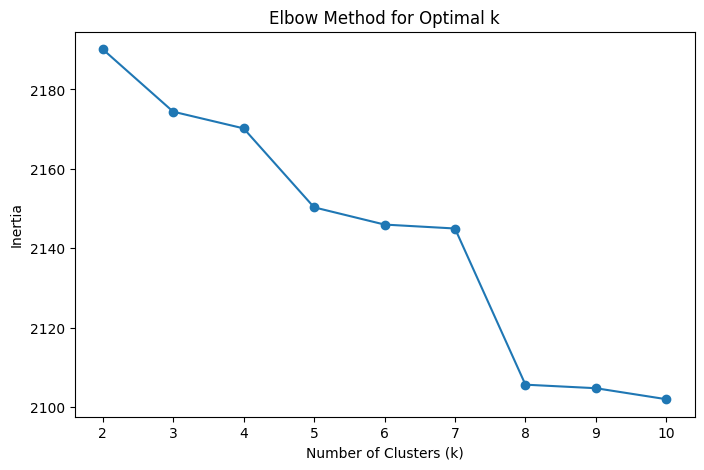

Cluster 0: ['differential privacy', 'privacy', 'federated learning', 'gan', 'deep learning', 'causal learning', 'membership inference attacks', 'language modelling', 'adversarial learning', 'robustness bound']
Cluster 1: ['reinforcement learning', 'continuous control', 'control', 'deep reinforcement learning', 'optimal control', 'deep learning', 'model predictive control', 'planning', 'multi-agent', 'variational inference']
Cluster 2: ['deep learning', 'representation learning', 'graph neural networks', 'generalization', 'generative models', 'optimization', 'neural networks', 'interpretability', 'neural architecture search', 'reinforcement learning']
Cluster 3: ['natural language processing', 'deep learning', 'language modeling', 'transformer', 'bert', 'natural language inference', 'machine translation', 'nlp', 'language generation', 'sequence modeling']
Cluster 4: ['disentanglement', 'representation learning', 'generative models', 'unsupervised learning', 'causality', 'counterfactuals

In [ ]:
# apply TF-IDF
df_grouped['keyword_str'] = df_grouped['keyword'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df_grouped['keyword_str'])


# Elbow Method for optimal k
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Clustering with optimal k
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_tfidf)

df_grouped['cluster_tfidf'] = labels


# show clusters keywords
for cluster_num in sorted(df_grouped['cluster_tfidf'].unique()):
    cluster_keywords = df_grouped[df_grouped['cluster_tfidf'] == cluster_num]['keyword'].sum()
    top_keywords = Counter(cluster_keywords).most_common(10)
    print(f"Cluster {cluster_num}: {[kw for kw, _ in top_keywords]}")



The keyword composition of each cluster suggests that the TF-IDF + KMeans pipeline successfully captures coherent topical groupings. For example, Cluster 1 is focused on reinforcement learning and control; Cluster 3 clearly centers on NLP and transformer-based models. Although some overlap exists across clusters (the recurrence of "deep learning"), the presence of distinct dominant themes confirms that even with a simple, low-cost representation like TF-IDF on keywords, meaningful thematic structure can be recovered.

<br> To better understand and visualize the spatial structure of the TF-IDF-based clusters, we apply <b>Principal Component Analysis (PCA)</b> to project the high-dimensional vectors into 3D.

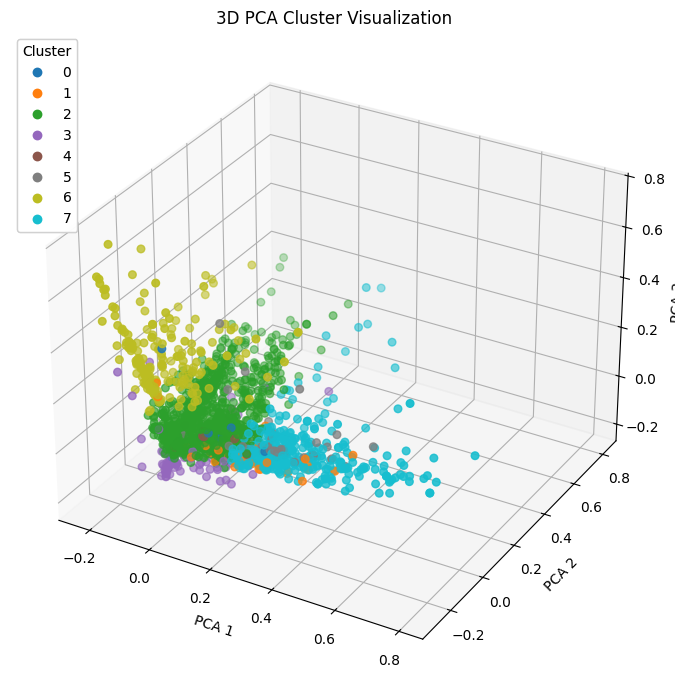

In [ ]:
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_tfidf.toarray())

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
    c=df_grouped['cluster_tfidf'], cmap='tab10', s=30
)

ax.set_title('3D PCA Cluster Visualization')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
legend = ax.legend(*scatter.legend_elements(), title="Cluster", loc='upper left')
ax.add_artist(legend)

plt.tight_layout()
plt.show()


The 3D projection reveals a reasonable separation between several clusters, with some partial overlap expected due to dimensionality reduction.

for the second part we will use a more powerfull che cattura la semantica method for the embedding. We can use word2vec or SBERT, where word2vec creates word-by-word vectors; requires a way to aggregate (average, sum, etc.) the vectors if you want a representation by sentence/document. And Sentence-Bert (SBERT) trasforma direttamente un’intera frase o documento in un singolo embedding denso. Word2Vec is computationaly more efficient, but for the context of the analysis where we reason on the abstract, it is more usefull to use SBERT

To capture deeper semantic relationships between papers, we now shift to a contextual embedding approach using <strong>Sentence-BERT (SBERT)</strong> — a modification of BERT specifically designed for producing sentence-level embeddings suitable for tasks like clustering and semantic search.

According to Reimers & Gurevych (2019) a key advantage of SBERT lies in its architecture: while standard BERT is effective for pairwise classification, it is not optimized for generating standalone embeddings. In fact, computing the most similar pair among n sentences with BERT requires O(n²) pairwise evaluations. SBERT solves this by introducing a siamese network architecture, where each sentence is encoded independently into a fixed-size vector. This allows for efficient comparisons via cosine similarity and makes SBERT especially suitable for large-scale semantic clustering.

Unlike TF-IDF, which represents documents as sparse vectors based on word frequency, SBERT embeddings encode contextual meaning.


In [ ]:
!pip install sentence-transformers
!pip install hdbscan
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/127.9 MB 110.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.5 MB/s eta 0:00:00
ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone m

We use the pre-trained all-MiniLM-L6-v2 model from the SentenceTransformer library to generate dense embeddings for each paper abstract. This model is compact and efficient.

Once encoded, we cluster the embeddings using KMeans with the same number of clusters (k = 8) used in the TF-IDF pipeline for comparison.

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

texts = df_grouped['abstract'].fillna('').tolist()

# create embeddings
embeddings = model.encode(texts, show_progress_bar=True, batch_size=32)

# clustering
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

df_grouped['cluster_sbert'] = labels


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/80 [00:00<?, ?it/s]

We now visualize the SBERT-based clusters in 3D using PCA, as previously done for the TF-IDF representation. This allows for a direct comparison between the two approaches in terms of cluster separability and structure.

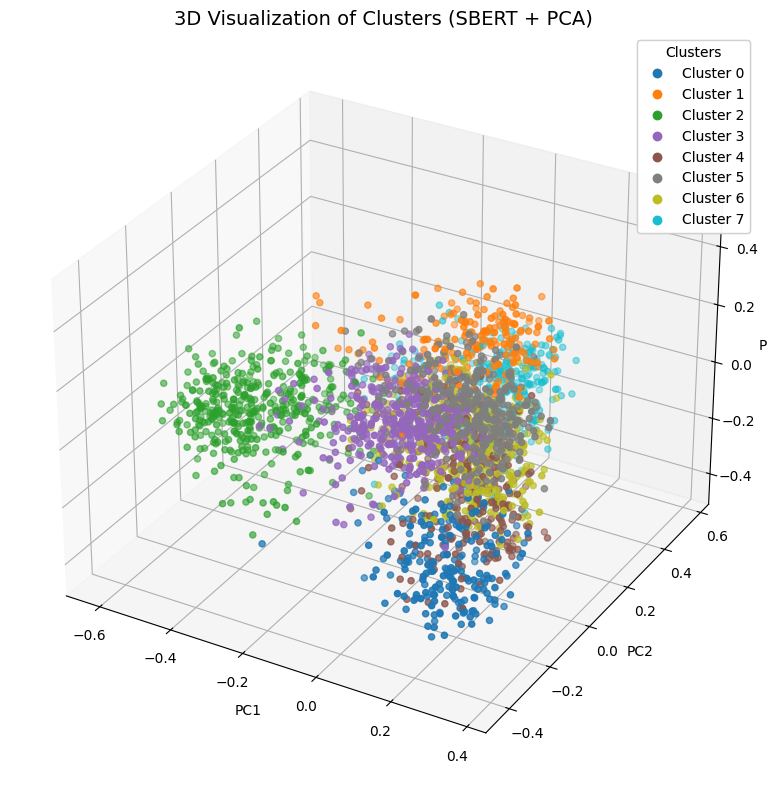

In [ ]:
pca = PCA(n_components=3, random_state=42)
embeddings_3d = pca.fit_transform(embeddings)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],
    c=labels, cmap='tab10', s=20
)

ax.set_title('3D Visualization of Clusters (SBERT + PCA)', fontsize=14)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

legend_labels = [f'Cluster {i}' for i in range(n_clusters)]
legend = ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters')
ax.add_artist(legend)

plt.tight_layout()
plt.show()


To compare the results of the two clustering pipelines — TF-IDF on keywords  and SBERT on abstracts — we analyze the size distribution of the clusters and compute the Normalized Mutual Information (NMI) between the two labelings.

NMI is an information-theoretic metric that measures the agreement between two clustering assignments, defined as:
<p>
NMI(U, V) = (2 &times; I(U; V)) / (H(U) + H(V))
</p>

<ul>
  <li><i>I(U; V)</i>: mutual information between clusterings <i>U</i> and <i>V</i></li>
  <li><i>H(U)</i>, <i>H(V)</i>: entropy of each clustering</li>
</ul>


NMI ranges from 0 (no mutual information) to 1 (perfect alignment). It is usefull for comparing two different clustering methods applied to the same dataset.


In [ ]:

print("Cluster TF-IDF (Pipeline A):")
print(df_grouped['cluster_tfidf'].value_counts().sort_index())

print("\nCluster SBERT (Pipeline B):")
print(df_grouped['cluster_sbert'].value_counts().sort_index())

nmi = normalized_mutual_info_score(df_grouped['cluster_tfidf'], df_grouped['cluster_sbert'])

print(f"Normalized Mutual Information (NMI): {nmi:.3f}")

Cluster TF-IDF (Pipeline A):
cluster_tfidf
0      12
1      37
2    1790
3      98
4      12
5      50
6     198
7     361
Name: count, dtype: int64

Cluster SBERT (Pipeline B):
cluster_sbert
0    216
1    187
2    411
3    362
4    323
5    341
6    397
7    321
Name: count, dtype: int64
Normalized Mutual Information (NMI): 0.223


The TF-IDF clusters are highly imbalanced, with one dominant group (Cluster 2) and several much smaller ones. In contrast, the SBERT clusters are more evenly distributed.

The NMI score of 0.223 indicates a low-to-moderate agreement between the two clusterings.

Based on the comparative analysis, we choose the SBERT-based clusters as the final representation for the rest of the study.

To better interpret the semantic clusters produced by SBERT, we analyze each group along three dimensions:

- Top Keywords: Although the clustering is based on abstracts, reviewing the most frequent keywords in each group helps us label and understand their thematic focus, and it helps the comparison with the TF-IDF clusters.

- Acceptance Ratio: We compute the proportion of accepted and rejected papers per cluster.

- Reviewer Experience: We examine the average reviewer expertise per cluster to check whether certain research areas tend to attract more experienced reviewers.

In [ ]:
print("\n--- Top Keywords per Cluster ---")
for cluster in sorted(df_grouped['cluster_sbert'].unique()):
    cluster_keywords = df_grouped[df_grouped['cluster_sbert'] == cluster]['keyword'].sum()
    top_keywords = Counter(cluster_keywords).most_common(10)
    print(f"Cluster {cluster}: {[kw for kw, _ in top_keywords]}")


print("\n--- Acceptance Ratio per Cluster ---")
acceptance_stats = df_grouped.groupby('cluster_sbert')['paper_decision'].value_counts(normalize=True).unstack().fillna(0)
print(acceptance_stats)


print("\n--- Experience Average Reviewers by Cluster ---")
reviewer_experience = df_grouped.groupby('cluster_sbert')['reviewer_level'].mean()
print(reviewer_experience)



--- Top Keywords per Cluster ---
Cluster 0: ['adversarial examples', 'adversarial robustness', 'robustness', 'adversarial training', 'deep learning', 'adversarial attack', 'adversarial defense', 'differential privacy', 'adversarial machine learning', 'adversarial attacks']
Cluster 1: ['graph neural networks', 'graph neural network', 'representation learning', 'deep learning', 'graph convolutional networks', 'graph classification', 'graph representation learning', 'graph embedding', 'node classification', 'graph pooling']
Cluster 2: ['reinforcement learning', 'deep reinforcement learning', 'deep learning', 'imitation learning', 'exploration', 'representation learning', 'transfer learning', 'hierarchical reinforcement learning', 'multi-agent reinforcement learning', 'meta-learning']
Cluster 3: ['deep learning', 'optimization', 'generalization', 'continual learning', 'neural networks', 'catastrophic forgetting', 'adam', 'sgd', 'variational inference', 'meta-learning']
Cluster 4: ['genera

The top keywords associated with each SBERT-based cluster confirm that the clustering reflects coherent research themes.

Despite the semantic clustering being based on abstracts, the alignment with keywords confirms the interpretability and thematic cohesion of the resulting groups.

Looking at the acceptance ratios, most clusters exhibit similar rejection rates around 65–70%. However, Cluster 6 shows the highest rejection rate at 78%.  